In [1]:
import os
import pickle
from glob import glob

import climlab
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

SEED = 42
np.random.seed(SEED)

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-fedrl"
RECORDS_DIR = f"{BASE_DIR}/records"

EXP_ID = "test"

In [3]:
record_files = glob(f"{RECORDS_DIR}/*{EXP_ID}*/*/*.pkl")
ebm_dict = {}

for fp in record_files:
    step = int(fp.split("_")[-1].split(".")[0])
    with open(fp, "rb") as f:
        ebm_dict[step] = pickle.load(f)

In [4]:
DATASETS_DIR = f"{BASE_DIR}/datasets"

fp_Ts = f"{DATASETS_DIR}/skt.sfc.mon.1981-2010.ltm.nc"
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"


def download_and_save_dataset(url, filepath, dataset_name):
    if not os.path.exists(filepath):
        print(f"Downloading {dataset_name} data ...")
        dataset = xr.open_dataset(url, decode_times=False)
        dataset.to_netcdf(filepath, format="NETCDF3_64BIT")
        print(f"{dataset_name} data saved to {filepath}")
    else:
        print(f"Loading {dataset_name} data ...")
        dataset = xr.open_dataset(
            filepath,
            decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        )
    return dataset


ncep_Ts = download_and_save_dataset(
    ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc",
    fp_Ts,
    "NCEP surface temperature",
).sortby("lat")

lat_ncep = ncep_Ts.lat
lon_ncep = ncep_Ts.lon
Ts_ncep_annual = ncep_Ts.skt.mean(dim=("lon", "time"))

Loading NCEP surface temperature data ...


In [5]:
a0_ref = 0.354
a2_ref = 0.25
D_ref = 0.6
A_ref = 2.1
B_ref = 2.0

num_lat = 96

nSteps_Episode = 200
nSteps = nSteps_Episode * 10
nEnsembles = 100

In [6]:
climlab_ebm = climlab.EBM_annual(
    a0=a0_ref,
    a2=a2_ref,
    D=D_ref,
    A=A_ref * 1e2,  # effective A (around 210)
    B=A_ref,
    num_lat=num_lat,
)
climlab_ebm.Ts[:] = 50.0  # initialise temperature state

for i in range(nSteps):
    climlab_ebm.step_forward()

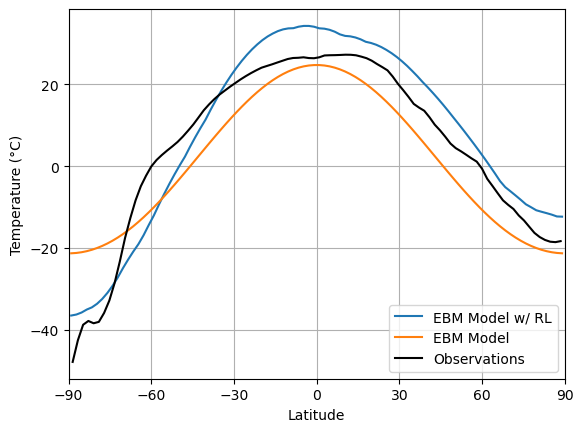

In [7]:
fig = plt.figure()
ax = fig.gca()

step = 10000
ebm_lat = climlab_ebm.lat
ebm_Ts = ebm_dict[step].reshape(-1)

ax.plot(ebm_lat, ebm_Ts, label="EBM Model w/ RL")
ax.plot(climlab_ebm.lat, climlab_ebm.Ts, label="EBM Model")
ax.plot(lat_ncep, Ts_ncep_annual, label="Observations", c="k")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Latitude")
ax.set_xlim(-90, 90)
ax.set_xticks(np.arange(-90, 91, 30))
ax.legend()
ax.grid()